# 1. Evaluating your broker's FX data with Pandas

Brokers deliver you with their best bid and ask prices they can offer. However, as the foreign exchange market is a distributed market, hundreds of brokers are available and not all of them are considered trustworthy. Brokers have to generate revenue from their services. They mostly achieve that by increasing the spread: if you buy a currency pair and sell it without the price moving, you lose the spread and the broker gained money. In other words, as a trader, the odds are not really in your favor if you don't know what you're doing. 

In this notebook, we will look at two important aspects of the data you got to verify that your broker is serving you quality data:
1. Missing data
2. Spread stability

The most important take away is that FX data depends on your broker! Therefore we should always be analysing our own broker's data before feeding it to trading algorithms. For convenience, I have provided the dataset of the EURGBP currency pair for 2019. The data is sampled per minute and represented in OHLC (see `datasets/EURGBP_M1_2019.csv`).

## 1.1 Missing data

Let's start with importing our standard packages.

In [16]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

register_matplotlib_converters()
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")


Next, we will load the dataset.

In [17]:
col_names = ['date', 'time', 'open', 'high', 'low', 'close', 'tickvol', 'vol', 'spread']
dataset_filename = 'datasets/EURGBP_M1_2019.csv'
df = pd.read_csv(dataset_filename, sep='\t', header=0, names=col_names, parse_dates=[['date', 'time']], index_col=0)
df.head()

,open,high,low,close,tickvol,vol,spread
date_time,,,,,,,
2019-01-02 09:05:00,0.90030,0.90041,0.90030,0.90033,51,0,19
2019-01-02 09:06:00,0.90034,0.90039,0.90028,0.90033,95,0,18
2019-01-02 09:07:00,0.90033,0.90033,0.90018,0.90018,45,0,19
2019-01-02 09:08:00,0.90018,0.90028,0.90018,0.90028,48,0,19
2019-01-02 09:09:00,0.90028,0.90032,0.90024,0.90026,36,0,19


As true data scientists, we should always first verify that the columns of our tables do not contain NaN values. This notebook however is not concerned with NaN values or incomplete rows. Dealing with those will be handled in a different chapter. However, a first and foremost sanity check to this end is to make sure the datatype of each column is as expected. In our case, the `open, high, low, close` columns should be floats and `tickvol, vol, spread` integers.

In [18]:
df.dtypes

open       float64
high       float64
low        float64
close      float64
tickvol      int64
vol          int64
spread       int64
dtype: object

In [19]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

With the datatypes verified, a second sanity check is to verify no anomalous price values are present (e.g. 0). Here, we will only look at the closing price.

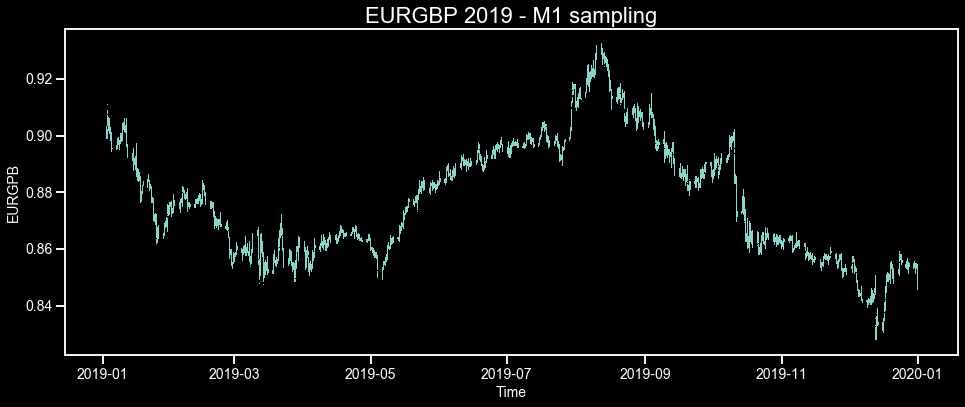

In [22]:
def plot_fx(close, title="", ylabel="Currency Pair", style='-'):
    plt.figure(figsize=(16,6))
    plt.plot(close, style)
    plt.title(title, fontsize=22)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

plot_fx(df.close, title="EURGBP 2019 - M1 sampling", ylabel="EURGPB", style=',')

The EURGBP rate does not seem to contain extreme outliers or easy-to-find anomalies (y-axis). We do however notice a lot of gaps in time (x-axis)! We will investigate these further by plotting the closing **price change per minute** versus **the sample duration** (the time between two samples).

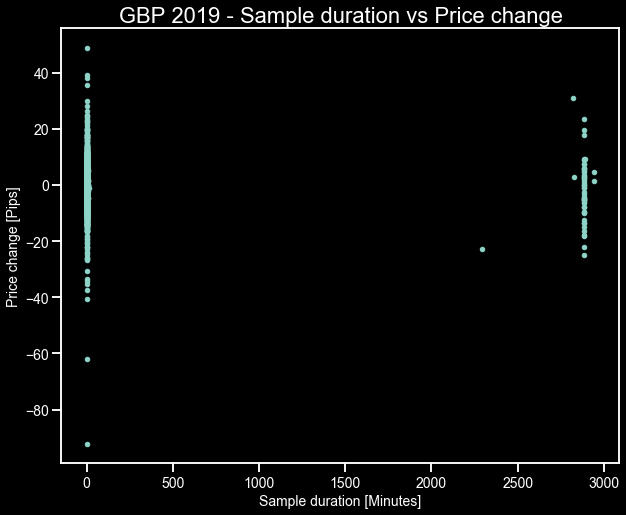

In [23]:
def plot_scatter(x, y, title="", xlabel="", ylabel="", style='.'):
    plt.figure(figsize=(10,8))
    plt.plot(x,y, style)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=22)
    plt.show()   
    
ts = pd.Series(df.index, index=df.index)
ts_diff = ts.diff()
ts_diff_min = ts_diff / np.timedelta64(1, 'm')
close_diff = df.close.diff() * 10**4
plot_scatter(ts_diff_min, close_diff, 
             title="GBP 2019 - Sample duration vs Price change", 
             xlabel="Sample duration [Minutes]", 
             ylabel="Price change [Pips]")

Interestingly, although the data is sampled per minute, sometimes it takes almost 3000 minutes for the next sample to arrive! How is that possible? Weekends, of course! Let's verify this claim by having a closer look at the samples with a long sample duration.

In [25]:
outliers = ts_diff > np.timedelta64(500, 'm')
ts_outliers = ts_diff.loc[outliers]
ts_outliers

date_time
2019-01-07 00:00:00   2 days 00:03:00
2019-01-14 00:00:00   2 days 00:03:00
2019-01-21 00:00:00   2 days 00:03:00
2019-01-28 00:00:00   2 days 00:03:00
2019-02-04 00:00:00   2 days 00:03:00
2019-02-11 00:00:00   2 days 00:03:00
2019-02-18 00:00:00   2 days 00:03:00
2019-02-25 00:00:00   2 days 00:03:00
2019-03-04 00:00:00   2 days 00:03:00
2019-03-10 23:00:00   1 days 23:03:00
2019-03-17 23:00:00   2 days 00:03:00
2019-03-24 23:00:00   2 days 00:03:00
2019-04-01 00:00:00   2 days 01:03:00
2019-04-08 00:00:00   2 days 00:03:00
2019-04-15 00:00:00   2 days 00:03:00
2019-04-22 00:00:00   2 days 00:03:00
2019-04-29 00:00:00   2 days 00:03:00
2019-05-06 00:00:00   2 days 00:03:00
2019-05-13 00:00:00   2 days 00:03:00
2019-05-20 00:00:00   2 days 00:03:00
2019-05-27 00:00:00   2 days 00:03:00
2019-06-03 00:00:00   2 days 00:03:00
2019-06-10 00:00:00   2 days 00:03:00
2019-06-17 00:00:00   2 days 00:03:00
2019-06-24 00:00:00   2 days 00:03:00
2019-07-01 00:00:00   2 days 00:03:00
20

Indeed, most of these outliers are about two days! However, there are five odd cases:
* 2019-03-10 23:00:00   1 days 23:03:00
* 2019-04-01 00:00:00   2 days 01:03:00
* 2019-10-27 23:02:00   1 days 23:05:00
* 2019-11-04 00:00:00   2 days 01:03:00
* 2019-12-26 09:05:00   1 days 14:15:00

Luckily, we can also explain those. Winter and summer time are not introduced on the same date in every country. Therefore sometimes the market opens on Monday an hour early or an hour later with respect to Eastern Standard Time (EST) which is the origin of our timestamps. The last timestamp is rather strange but it's also the day after Christmas!

The previous plot showed that Weekends can cause confusion in our sample durations. **However, these are to be expected and are no fault of our broker!** Let's remove those cases and see if we can find gaps in time where there shouldn't be any.

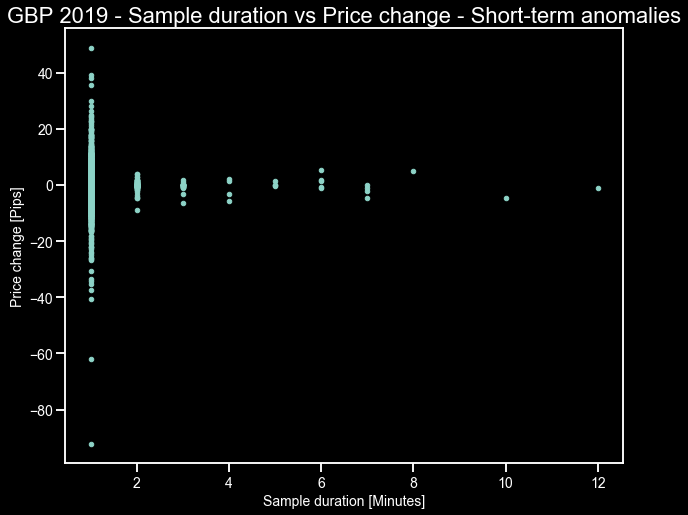

In [26]:
inliers = ts_diff_min < 500
plot_scatter(ts_diff_min[inliers], close_diff[inliers], 
             title="GBP 2019 - Sample duration vs Price change - Short-term anomalies", 
             xlabel="Sample duration [Minutes]", 
             ylabel="Price change [Pips]")

Ahaa! Our broker is missing data! Although the market is moving on every minute of a weekday, we find sample durations that are sometimes significantly larger than 1 minute!

Let's go ahead and inspect one example of missing data on a chart to verify that the market has indeed been moving. We first gather all timestamps of anomalies (samples with a duration longer than 1 minute) in the `ts_inliers_gt1` dataframe. Then, we will visualise the first timestamp in MetaTrader 5.

In [27]:
ts_inliers = ts_diff_min[inliers]
ts_inliers_gt1 = ts_inliers[ts_inliers > 1]
ts_inliers_gt1.head()

date_time
2019-01-02 17:25:00    10.0
2019-01-04 00:01:00     2.0
2019-01-14 00:19:00     2.0
2019-01-14 09:37:00     8.0
2019-01-16 00:01:00     2.0
Name: date_time, dtype: float64

![EURGBP_metatrader_missingdata](images/EURGBP_metatrader_missingdata_marked.PNG)

Notice the huge gap?! The candle at 17:15 closes with a rate of `0.9005`. The next candle is only given at 17:25, opening at a little over `0.9001`. That 10 minutes of missing data is worth 3.8 Pips! Although gaps of 10 minutes or longer are extremely rare in the data, they are a potential source of risk during trading, or may cause confusion during model training. 

One statistic to estimate the quality of the data is the amount of anomaly gaps with respect to the total number of samples:

In [28]:
anomalies_percentage = np.sum(ts_diff_min[inliers] > 1) / ts_diff_min.shape[0] * 100
print("Amount of inlier samples with a duration >1 minute: %.2f%%" % anomalies_percentage)

Amount of inlier samples with a duration >1 minute: 0.05%


As a gap indicates at least one missing sample, we find that at least 1 in 2000 samples is missing.

## 1.2 Spread Stability

The spread is determined by our broker, and is the difference between the lowest ask and the highest bid price. Analysing the spread is very important as they will directly impact the size of our profits. As traders, we want spreads to be as small as possible and spreads to be stable! Why? Smaller spreads simply means that the price needs to move less for us to be profitable. Stability is extremely important so the spread doesn't alter significantly between the time we place an order and the time it gets executed, which could again significantly impact our profits and losses.

Let's start out by looking at some simple statistics:

In [29]:
s_min = df.spread.min()
s_max = df.spread.max()
s_mean = df.spread.mean()
s_median = df.spread.median()

print("Spread minimum: {} pipettes\nSpread maximum: {} pipettes\nSpread mean: {} pipettes\nSpread median: {} pipettes".format(s_min, s_max, s_mean, s_median))

Spread minimum: 13 pipettes
Spread maximum: 140 pipettes
Spread mean: 20.710038157131876 pipettes
Spread median: 19.0 pipettes


Holy Moly! The spread can move between 1.3 and 14 pips! The median spread however is only 1.9 pips, which is acceptable. Let's visualise the cumulative sum of the spreads and figure out the probablity of encoutering an exceptionally large spread.

In [30]:
s_bins = df.spread.groupby(df.spread).count()
s_prop = s_bins / s_bins.sum()
s_cumprop = s_prop.cumsum()
s_99p = s_cumprop.index[s_cumprop < 0.99][-1]
print("With a chance slightly larger than 1%, the spread is larger than {} pipettes.".format(s_99p))

With a chance slightly larger than 1%, the spread is larger than 69 pipettes.


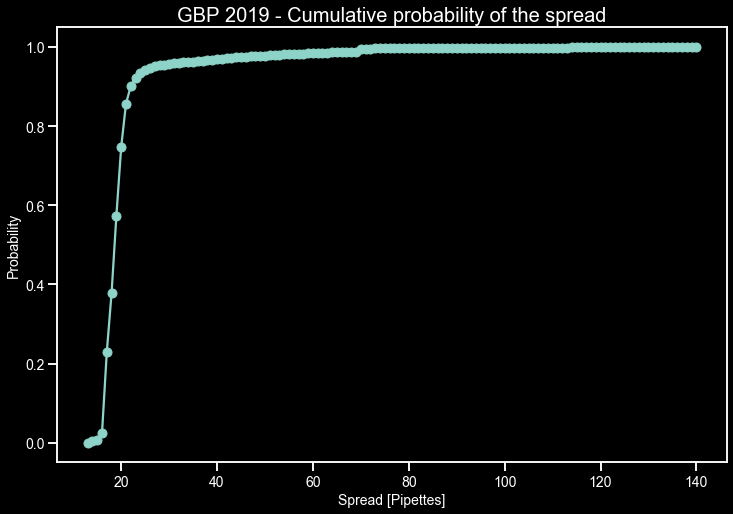

In [34]:
def myLinePlot(x,y,xlabel,ylabel,title):
    plt.figure(figsize=(12,8))
    plt.plot(x,y, '-o')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=20)
    plt.show() 

myLinePlot(s_cumprop.index,s_cumprop, "Spread [Pipettes]", "Probability", "GBP 2019 - Cumulative probability of the spread")

That's very impressive! And not in a good way... Although on average the spread remains low, it often spikes above 69 pipettes and even upto 140 pipettes! But are the spikes on random moments? Or can we predict when they will most likely occur?

Let's visualise the average spread on a given hour of the week. To do that, we create a new column which will indicate the day of the week corresponding to the given date. Then we group the date on (1) the day of the week and (2) the hour of the day.

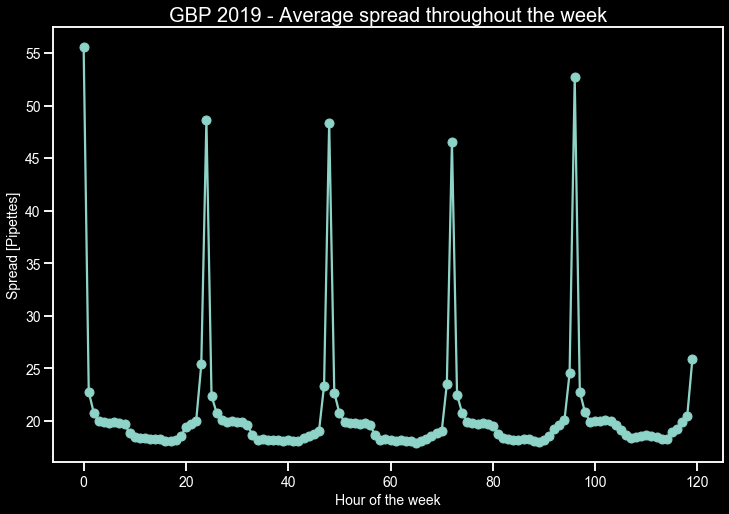

In [35]:
df_dow = df.copy()
df_dow['dayofweek'] = df.index.dayofweek
group_dayhour = df_dow.spread.groupby([df_dow.dayofweek, df_dow.index.hour])
gdh_mean = pd.DataFrame(group_dayhour.mean())
gdh_mean['hourofweek'] = np.arange(gdh_mean.shape[0])

gdh_mean_withoutsunday = gdh_mean[:-1]

myLinePlot(gdh_mean_withoutsunday.hourofweek,gdh_mean_withoutsunday.spread, "Hour of the week", "Spread [Pipettes]", "GBP 2019 - Average spread throughout the week")

It looks like our broker's spread spikes with perfect consistency! That is, every time around midnight EST. A possible reason is that the end of the day triggers a lot of orders, however more research will have to be done! It is however clear that we should be aware of such behaviour in our broker data. They can provide profitable opportunities but also disastrous losses. 

Lastly, we will group the data only by the hour of the day. If you're trading strategy requires the smallest spreads, you should be trading between 10AM and 5PM EST.

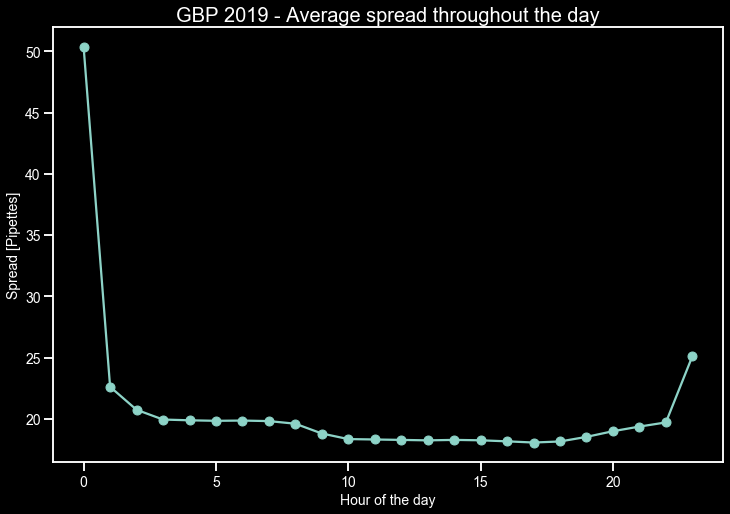

In [36]:
group_hour = df_dow.spread.groupby(df_dow.index.hour)
group_hour_mean = pd.DataFrame(group_hour.mean())
group_hour_mean.columns

myLinePlot(group_hour_mean.index,group_hour_mean.spread, "Hour of the day", "Spread [Pipettes]", "GBP 2019 - Average spread throughout the day")

Although this is the end of this chapter, it is obvious that a lot more analyses can be done! We could zoom in on the first hour of a day and further understand the spread behaviour of this broker in detail. We could also have a look at when gaps occur in the data and perhaps find patterns there. This brief tutorial is ment to introduce you to two important characteristics of a broker's data which every data science trader should look into: missing samples and spread stability. With some simple techniques, we can already conclude that if you use this broker, you may want to stay away from trading around midnight.

In the coming chapters, we will see how to compare different brokers in order to pick the best one for your trading strategy. Once we have a trustworthy broker, we will have a look at different currency pairs. Of course, we will also jump into actual trading algorithms! 

Alright future yacht owners, see you in the next chapter!